In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings('ignore')

import re
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

#sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, ndcg_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import random

# Set a fixed seed value
SEED = 42

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)

# Reading Files:

In [4]:
df_train = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
df_test = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
countries = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/countries.csv.zip')
sessions = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/sessions.csv.zip')
age_gender = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip')

In [5]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [7]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# EDA:

In [8]:
df_train.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

In [11]:
df_train.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [12]:
df_test.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [13]:
df_train[(df_train['age'] >= 100) | (df_train['age'] <= 13)].value_counts().sum()

1335

In [14]:
df_test[(df_test['age'] >= 100) | (df_test['age'] <= 13)].value_counts().sum()

0

In [15]:
df = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [16]:
sns.set_context("talk")
sns.set_style("whitegrid")

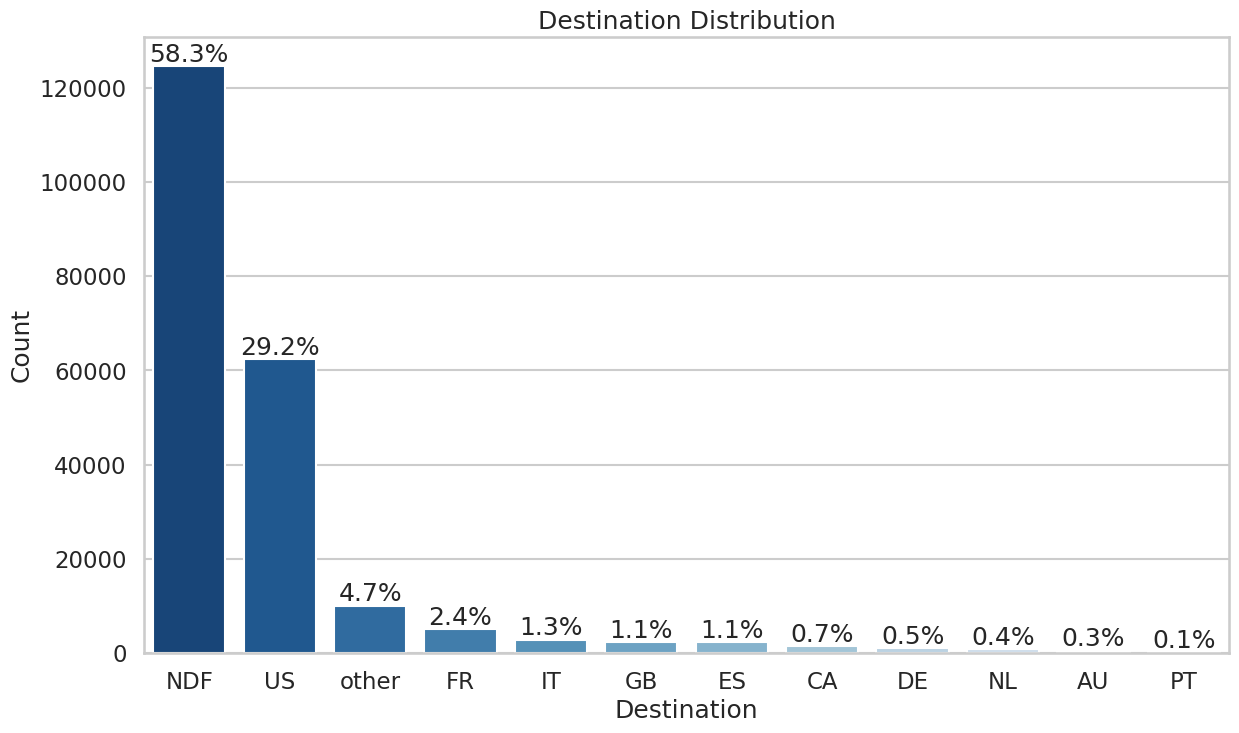

In [17]:
plt.figure(figsize=(14,8))
order1 = df['country_destination'].value_counts().index
sns.countplot(data = df, x = 'country_destination', order = order1, palette=sns.color_palette("Blues_r", 12))
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Destination Distribution')
order2 = df_train['country_destination'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_train.shape[0])
    plt.text(i,count+1000,strt,ha='center')

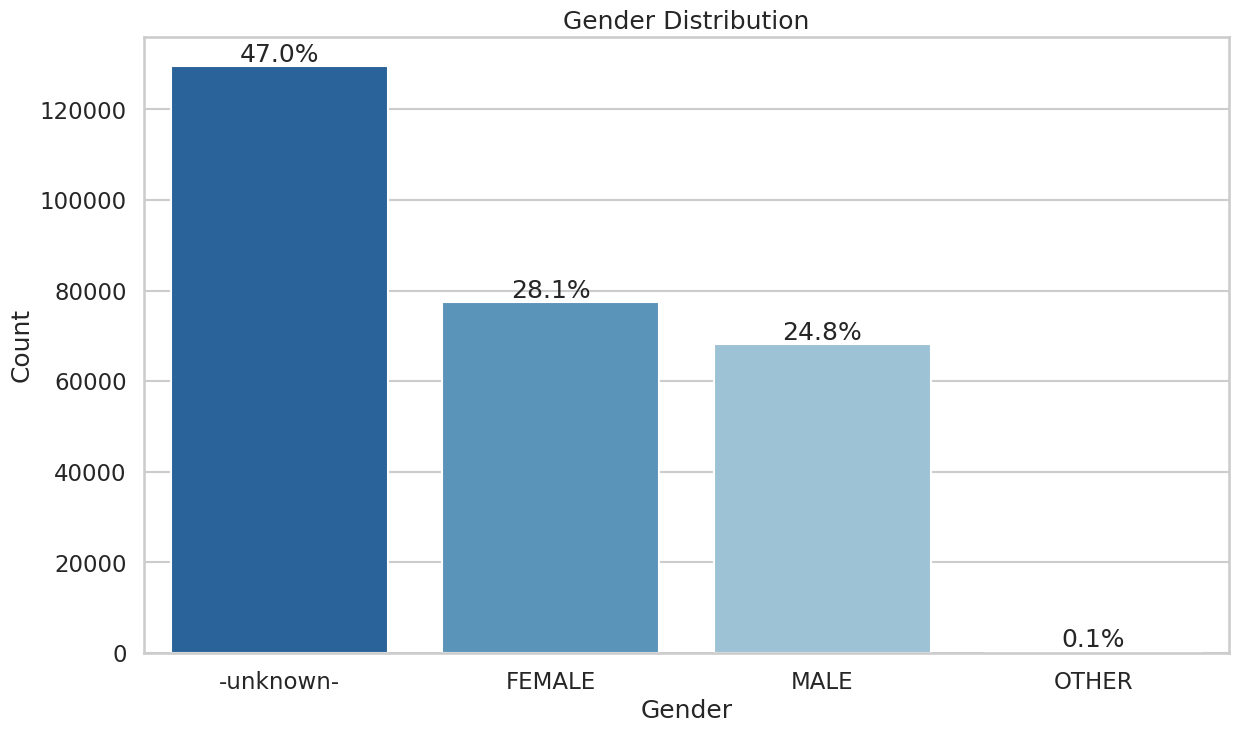

In [18]:
plt.figure(figsize=(14,8))
order1 = df['gender'].value_counts().index
sns.countplot(data = df, x = 'gender', order = order1, palette=sns.color_palette("Blues_r", n_colors=4))
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
order2 = df['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df.shape[0])
    plt.text(i,count+1000,strt,ha='center')

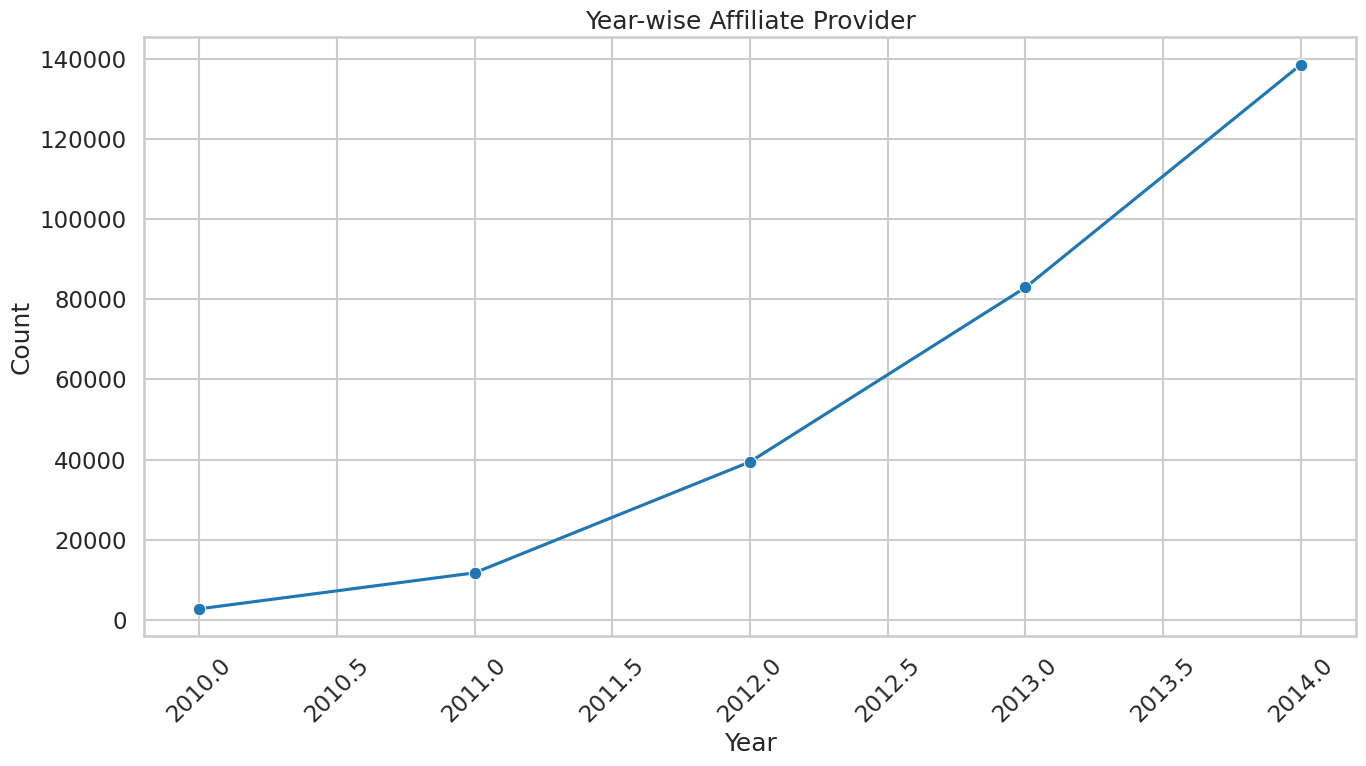

In [19]:
# Ensure acc_year is extracted correctly
df['date_account_created'] = pd.to_datetime(df['date_account_created'], errors='coerce')
df['acc_year'] = df['date_account_created'].dt.year

# Filter valid years
years = [2010, 2011, 2012, 2013, 2014]
df = df[df['acc_year'].isin(years)]

# Group properly: count of affiliate_provider per year
yearly_data = df.groupby('acc_year')['affiliate_provider'].count().reset_index()

# Optional: enforce order
yearsOrder = pd.api.types.CategoricalDtype(ordered=True, categories=years)
yearly_data['acc_year'] = yearly_data['acc_year'].astype(yearsOrder)

# Plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.set_context("talk")

sns.lineplot(data=yearly_data, x='acc_year', y='affiliate_provider', marker='o', color=sns.color_palette()[0])

plt.title('Year-wise Affiliate Provider')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


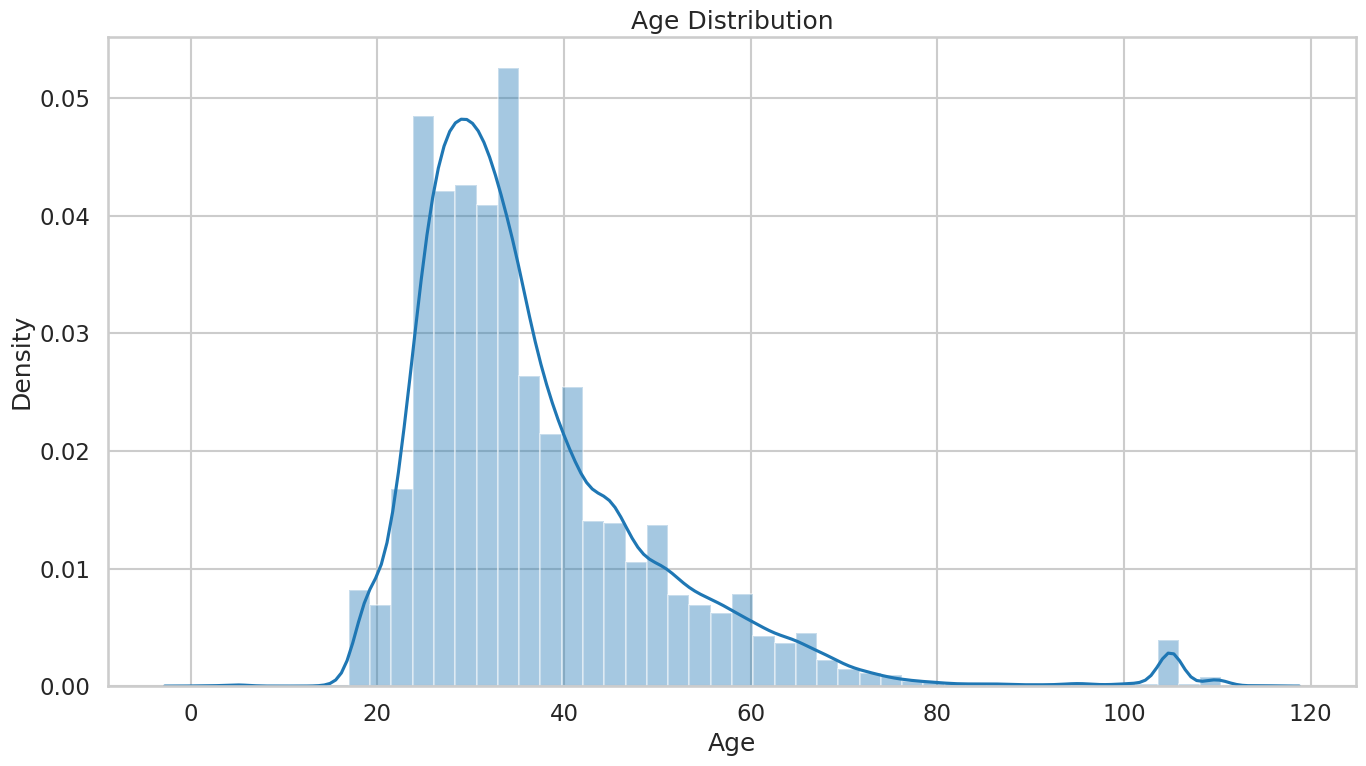

In [20]:
plt.figure(figsize=(14,8))
df_age = df[df['age']<=120]
sns.distplot(df_age, x= df_age['age']);
plt.xlabel('Age')
plt.title('Age Distribution')
plt.tight_layout()
plt.show()


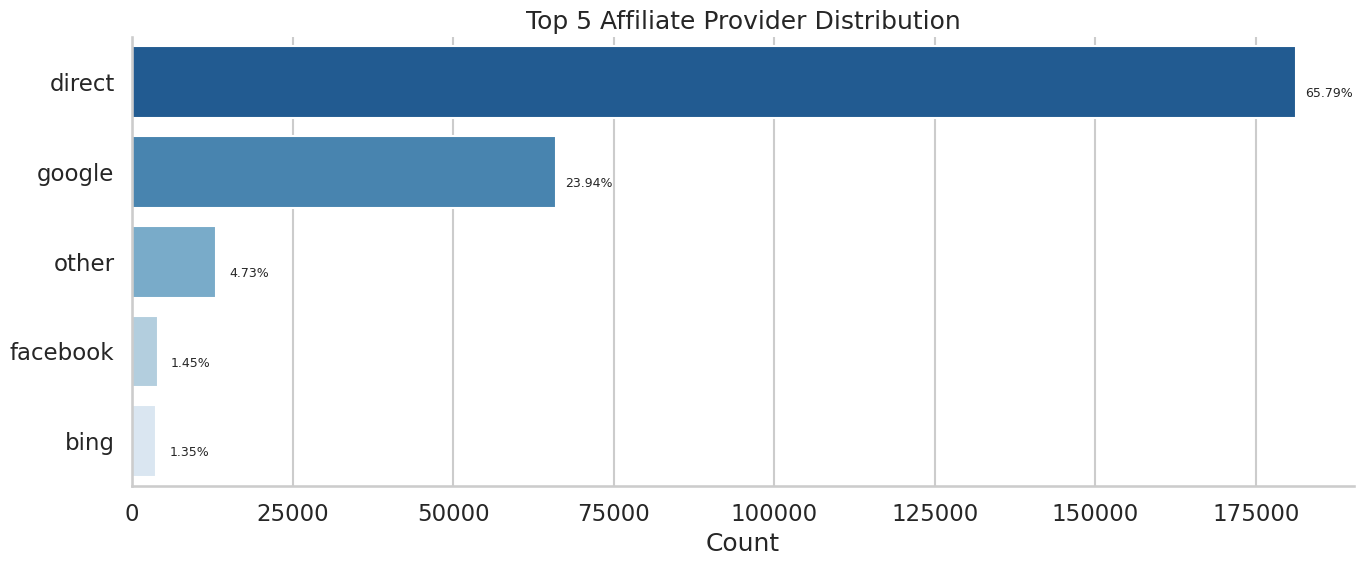

In [21]:
plt.figure(figsize=(14, 6))

# Get top 5 affiliate providers
counts = df['affiliate_provider'].value_counts().head(5)
counts_order = counts.index

# Use reversed blue palette for top 5
palette = sns.color_palette("Blues_r", n_colors=5)

sns.countplot(
    y=df['affiliate_provider'],
    order=counts_order,
    palette=palette
)

plt.xlabel('Count')
plt.ylabel('')  # Hide y-axis label
plt.title('Top 5 Affiliate Provider Distribution')

# Add percentage annotations
for i in range(counts.shape[0]):
    plt.text(counts[i] + 5200, i + 0.17, f"{counts[i]/df.shape[0]*100:0.2f}%", ha='center', fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()


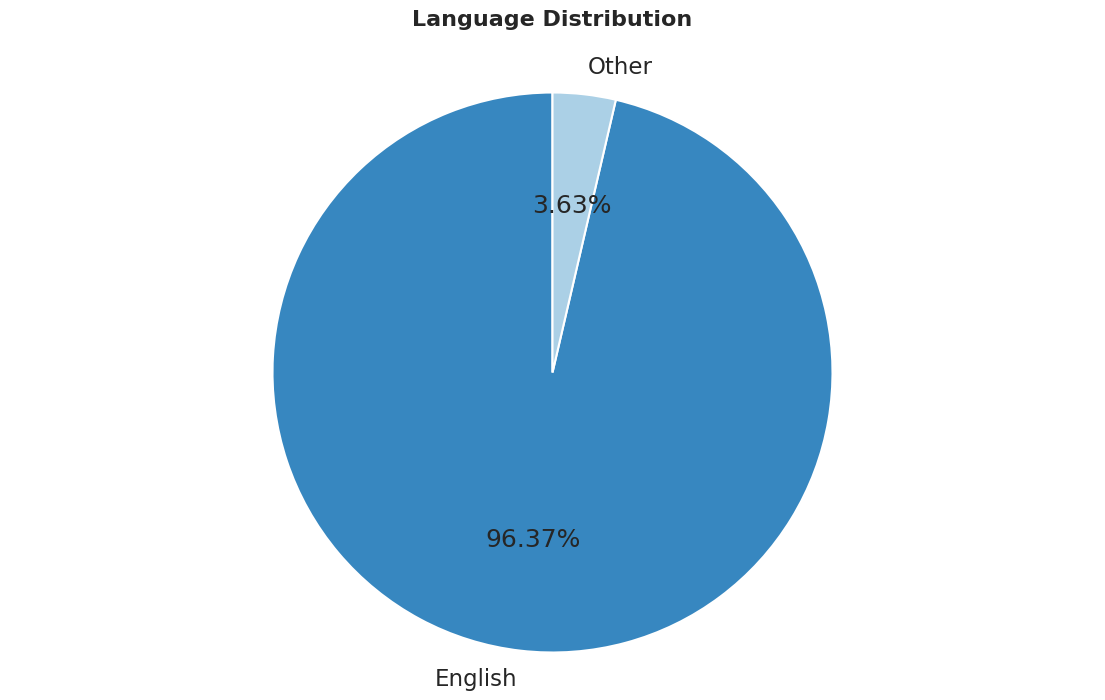

In [22]:
# Count the occurrences of 'en' vs. other languages
lang_counts = df['language'].value_counts()
en_count = lang_counts.get('en', 0)
other_count = lang_counts.sum() - en_count

# Data for pie chart
labels = ['English', 'Other']
sizes = [en_count, other_count]

# Plot the pie chart
plt.figure(figsize=(14, 8))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, 
        colors=sns.color_palette("Blues_r", n_colors=2))  # Exploding English slice for emphasis

# Add title and style, adjust y-position to raise the title
plt.title('Language Distribution', fontsize=16, fontweight='bold', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

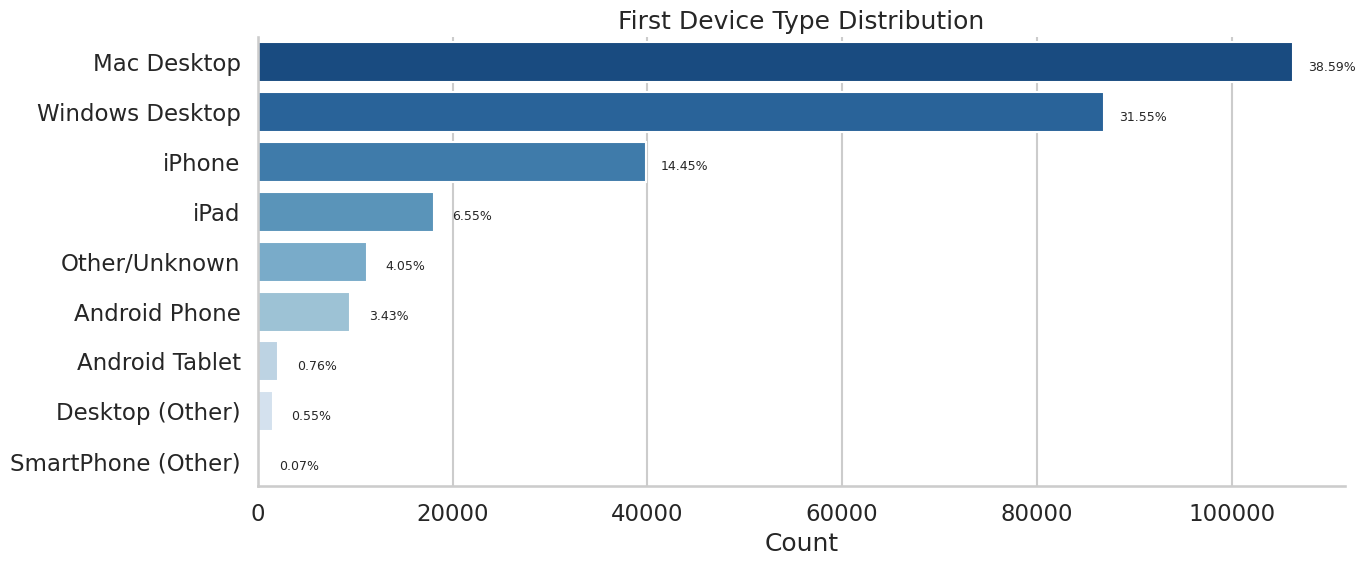

In [23]:
# Set figure size
plt.figure(figsize=(14, 6))

# Get the counts for the 'first_device_type' column
counts = df['first_device_type'].value_counts()
counts_order = counts.index

# Use reversed blue palette for countplot
palette = sns.color_palette("Blues_r", n_colors=counts.shape[0])

# Create the countplot
sns.countplot(
    y=df['first_device_type'],
    order=counts_order,
    palette=palette
)

# Set axis labels and title
plt.xlabel('Count')
plt.ylabel('')  # Hide y-axis label
plt.title('First Device Type Distribution')

# Add percentage annotations on the bars
for i in range(counts.shape[0]):
    plt.text(counts[i] + 4000, i + 0.17, f"{counts[i]/df.shape[0]*100:0.2f}%", ha='center', fontsize=9)

# Remove the top and right spines for a cleaner look
sns.despine()

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()


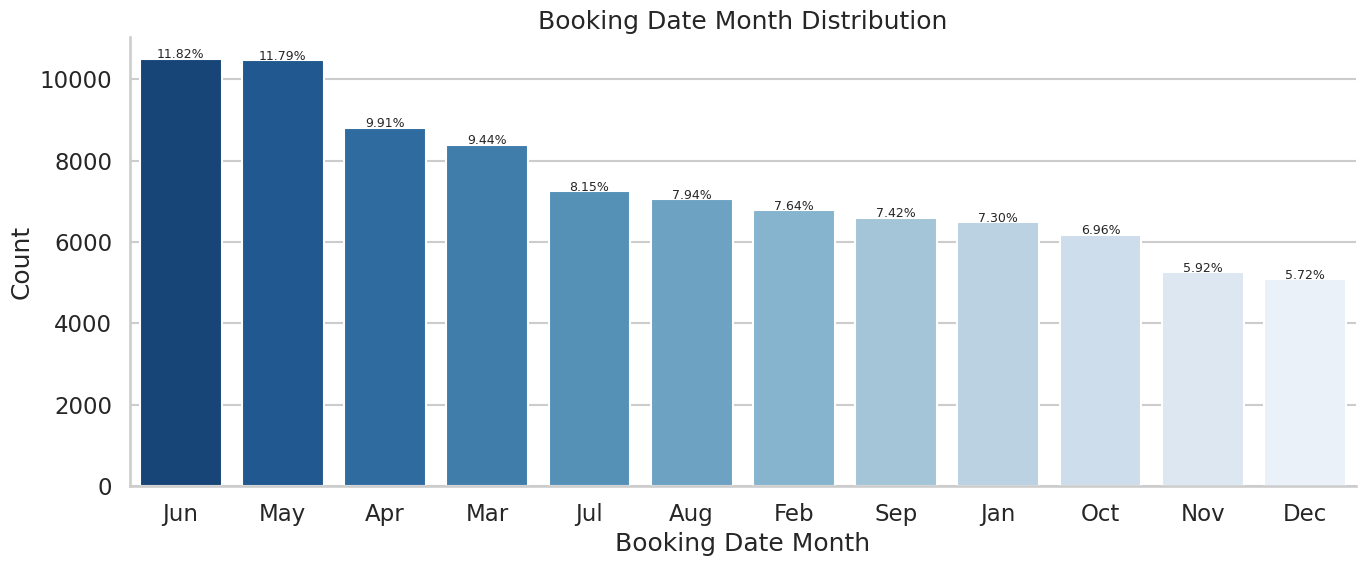

In [24]:
# Ensure 'date_first_booking' is in datetime format
df['date_first_booking'] = pd.to_datetime(df['date_first_booking'], errors='coerce')

# Set figure size
plt.figure(figsize=(14, 6))

# Extract month names
months_freq = df['date_first_booking'].dropna().dt.month_name().str[:3]

# Count the occurrences of each month
counts = months_freq.value_counts()

# Order the counts by index (month name order)
counts_order = counts.index

# Use a reversed color palette for the countplot
palette = sns.color_palette("Blues_r", n_colors=counts.shape[0])

# Plot the count of bookings by month
sns.countplot(x=months_freq, order=counts_order, palette=palette)

# Set axis labels and title
plt.xlabel('Booking Date Month')
plt.ylabel('Count')
plt.title('Booking Date Month Distribution')

# Add percentage annotations on the bars
for i, count in enumerate(counts):
    percentage = count / months_freq.shape[0] * 100
    plt.text(i, count + 10, f"{percentage:.2f}%", ha='center', fontsize=9)

# Remove the top and right spines for a cleaner look
sns.despine()

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()


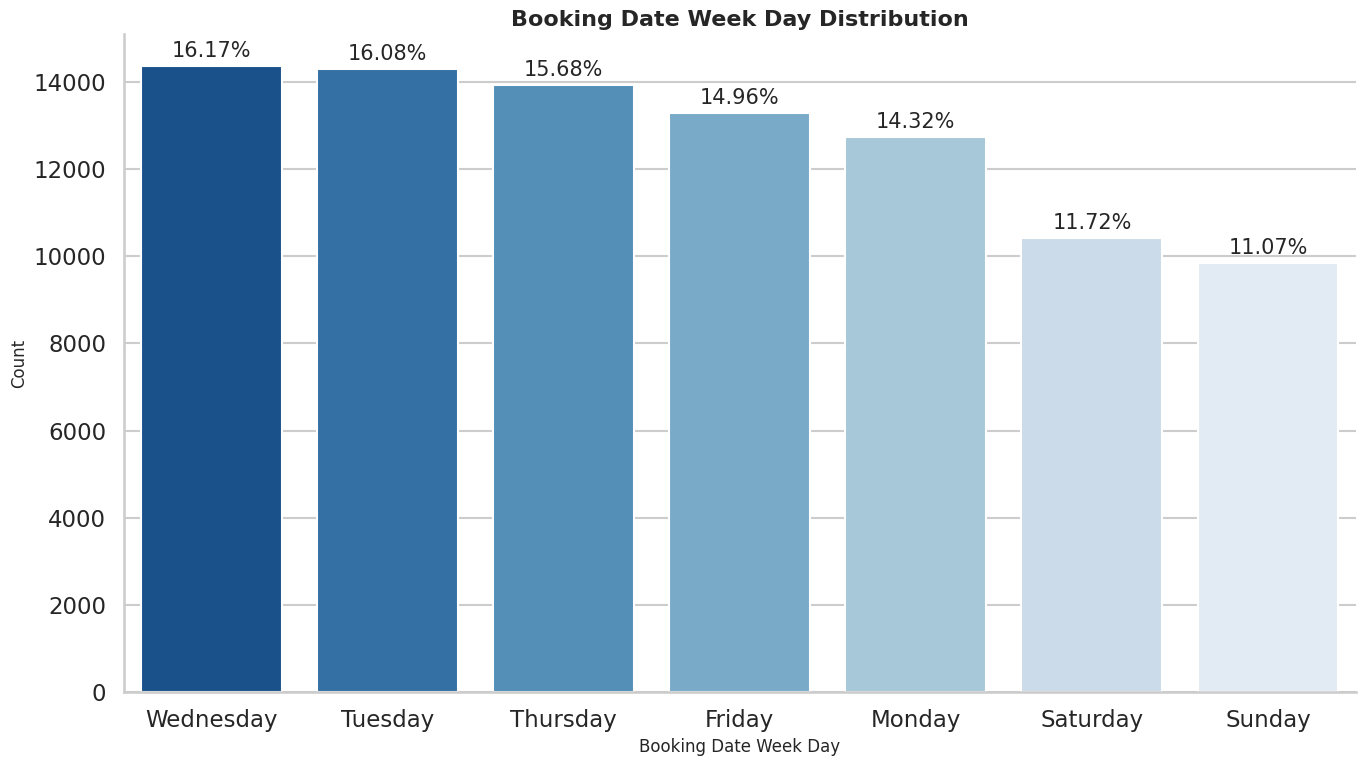

In [25]:
# Set figure size
plt.figure(figsize=(14, 8))

# Extract the day of the week from 'date_first_booking'
week_days_freq = df['date_first_booking'].dropna().dt.day_name()

# Count the occurrences of each weekday
counts = week_days_freq.value_counts()

# Order the counts by weekday order
counts_order = counts.index

# Plot the count of bookings by weekday with a reversed color palette
sns.countplot(x=week_days_freq, order=counts_order, palette=sns.color_palette("Blues_r", n_colors=counts.shape[0]))

# Set axis labels and title with better styling
plt.xlabel('Booking Date Week Day', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Booking Date Week Day Distribution', fontsize=16, fontweight='bold')

# Add percentage annotations on the bars with slight adjustments for clarity
for i in range(counts.shape[0]):
    plt.text(i, counts[i] + 200, f"{counts[i]/week_days_freq.shape[0]*100:0.2f}%", ha='center', fontsize=15)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()


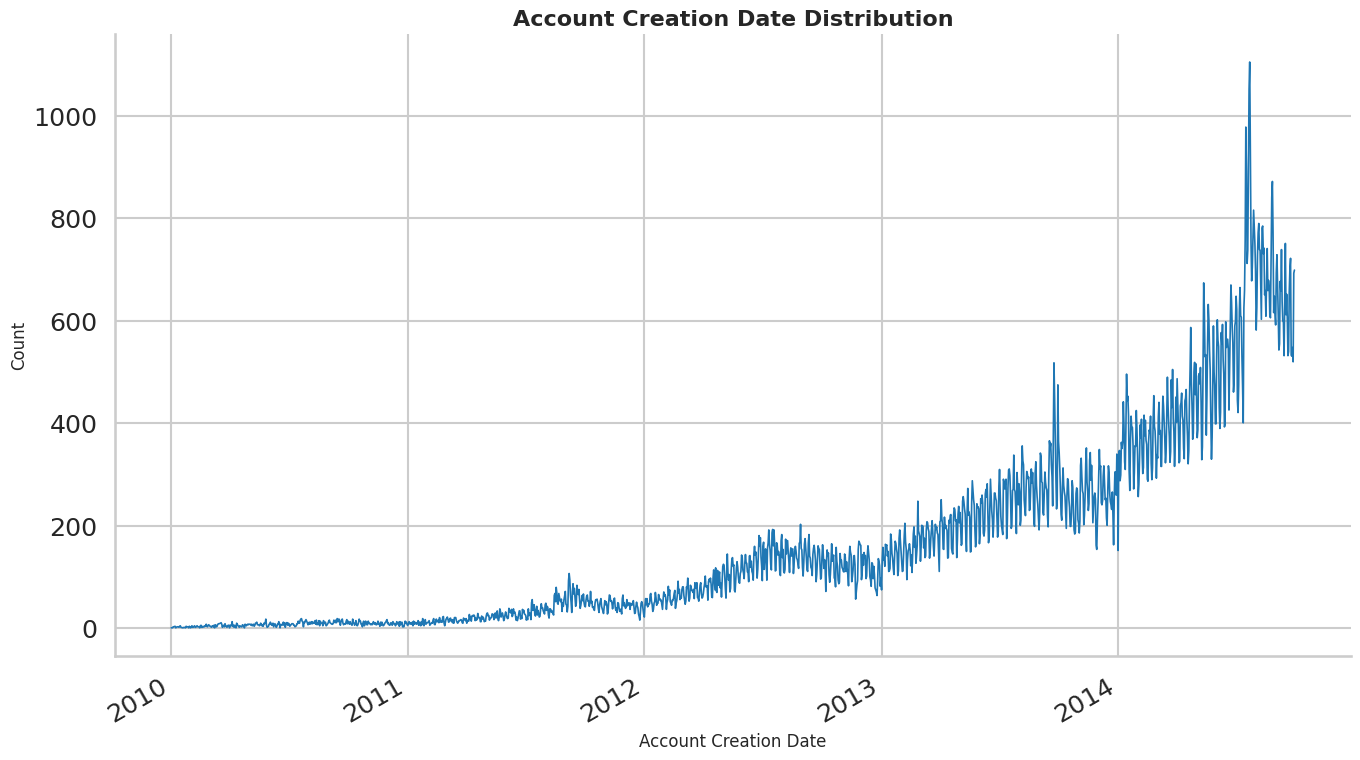

In [26]:
# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

# Assuming df is your DataFrame and 'date_account_created' is the column you're plotting
plt.figure(figsize=(14, 8))

# Create the line plot with blue color
df['date_account_created'].value_counts().sort_index().plot(kind='line', linewidth=1.2, color='#1f77b4')  # Blue color

# Set axis labels and title with appropriate style
plt.xlabel('Account Creation Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Account Creation Date Distribution', fontsize=16, fontweight='bold')

# Remove the top and right spines for a cleaner look
sns.despine()

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()


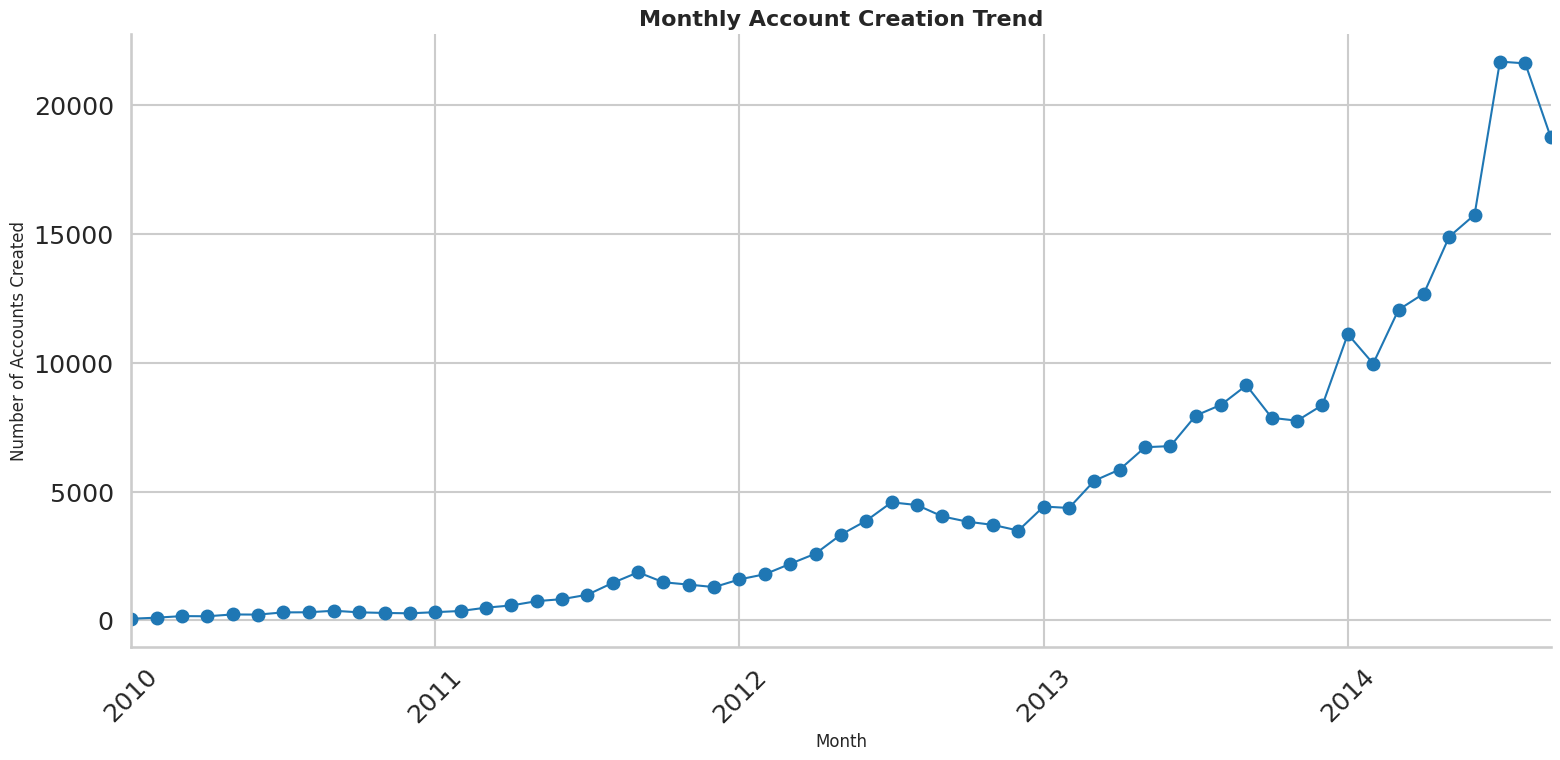

In [27]:
# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

# Ensure datetime is parsed
df['date_account_created'] = pd.to_datetime(df['date_account_created'], errors='coerce')

# Group by month
monthly_counts = df['date_account_created'].dt.to_period('M').value_counts().sort_index()
monthly_counts.index = monthly_counts.index.to_timestamp()  # Convert PeriodIndex to Timestamp for plotting

# Plot
plt.figure(figsize=(16, 8))
monthly_counts.plot(kind='line', linewidth=1.5, color='#1f77b4', marker='o')

# Labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Accounts Created', fontsize=12)
plt.title('Monthly Account Creation Trend', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)

# Clean look
sns.despine()
plt.tight_layout()
plt.show()

# Preprocessing:

## Dates:

In [28]:
def extract_date_features(df, column_name, prefix):
    """
    Extracts year, month, and day features from a date column and drops the original column.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the date column.
        column_name (str): The name of the date column to process.
        prefix (str): The prefix for the new feature columns.
    
    Returns:
        pd.DataFrame: DataFrame with extracted date features.
    """
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m-%d', errors='coerce')
    df[f'{prefix}_year'] = df[column_name].dt.year
    df[f'{prefix}_month'] = df[column_name].dt.month
    df[f'{prefix}_day'] = df[column_name].dt.day
    return df.drop(columns=[column_name])


In [29]:
df_train = extract_date_features(df_train, 'date_account_created', 'dac')
df_test = extract_date_features(df_test, 'date_account_created', 'dac')


In [30]:
df_train.drop('date_first_booking', inplace = True, axis = 1)
df_test.drop('date_first_booking', inplace = True, axis = 1)

In [31]:
def extract_timestamp_features(df, column_name):
    """
    Extracts year, month, day, hour, minute, and second from a timestamp column.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the timestamp column.
        column_name (str): Name of the timestamp column to process.
    
    Returns:
        pd.DataFrame: DataFrame with extracted features.
    """
    # Ensure the column is a string
    df[column_name] = df[column_name].astype(str)
    
    # Extract features
    df[f'{column_name}_year'] = df[column_name].str[:4].astype(int)
    df[f'{column_name}_month'] = df[column_name].str[4:6].astype(int)
    df[f'{column_name}_day'] = df[column_name].str[6:8].astype(int)
    df[f'{column_name}_hour'] = df[column_name].str[8:10].astype(int)
    df[f'{column_name}_minute'] = df[column_name].str[10:12].astype(int)
    df[f'{column_name}_second'] = df[column_name].str[12:14].astype(int)
    
    # Optionally, drop the original timestamp column
    df = df.drop([column_name], axis=1)
    
    return df

In [32]:
df_train = extract_timestamp_features(df_train, 'timestamp_first_active')
df_test = extract_timestamp_features(df_test, 'timestamp_first_active')

## Sessions:

In [33]:
sessions = sessions.groupby("user_id", as_index= False).agg(lambda x:x.tolist())

In [34]:
def convert_to_set(device):
    device = [str(i) for i in device]
    device = [re.sub("nan","",i) for i in device]
    device = ",".join(set(device))
    
    return device

def convert_the_time(time):
    
    float_time = []
    time = [str(i) for i in time]
    time = [re.sub("nan","",i) for i in time]
    
    for i in time:
        try:
            float_time.append(float(i))
        except ValueError :
            continue


    time = sum(float_time)
    
    return time

def convert_to_string(action):
    action = [str(i) for i in action]
    action = [re.sub("nan","",i) for i in action]
    action = ",".join(action)
    
    return action

In [35]:
sessions["action"] = sessions["action"].apply(convert_to_string)
sessions["action_type"] = sessions["action_type"].apply(convert_to_string)
sessions["action_detail"] = sessions["action_detail"].apply(convert_to_string)
sessions['device_type'] =sessions['device_type'].apply(convert_to_set)
sessions['secs_elapsed'] = sessions['secs_elapsed'].apply(convert_the_time)

In [36]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,00023iyk9l,"index,dashboard,header_userpic,dashboard,callb...","view,view,data,view,partner_callback,message_p...","view_search_results,dashboard,header_userpic,d...","Mac Desktop,iPhone",867896.0
1,0010k6l0om,"search_results,show,personalize,show,search_re...","click,view,data,,click,click,,data,view,partne...","view_search_results,p3,wishlist_content_update...",Mac Desktop,586543.0
2,001wyh0pz8,"search,search,search,show,social_connections,i...","click,click,click,view,data,-unknown-,view,-un...","view_search_results,view_search_results,view_s...",Android App Unknown Phone/Tablet,282965.0
3,0028jgx1x1,"show,reviews,show,search,show,search,reviews,c...","view,data,view,click,view,click,data,submit,-u...","user_profile,listing_reviews,p3,view_search_re...","Android Phone,-unknown-",297010.0
4,002qnbzfs5,"social_connections,payment_methods,create,show...","data,-unknown-,-unknown-,view,data,data,data,,...","user_social_connections,-unknown-,-unknown-,us...","iPhone,-unknown-",6487080.0


# Encoding:

In [37]:
X_df_train, X_df_val, y_train, y_val = train_test_split(df_train.drop(columns=['country_destination']), df_train['country_destination'],
                                                        test_size=0.2, random_state=42, stratify=df_train['country_destination'])

## Merging With Sessions:

In [38]:
X_df_train = X_df_train.merge(sessions, left_on='id', right_on='user_id', how='left')
X_df_val = X_df_val.merge(sessions, left_on='id', right_on='user_id', how='left')
df_test = df_test.merge(sessions, left_on='id', right_on='user_id', how='left')

## Age:

In [39]:
'''
X_df_train.loc[(X_df_train['age'] >= 100) | (X_df_train['age'] <= 15), 'age'] = np.nan
X_df_val.loc[(X_df_val['age'] >= 100) | (X_df_val['age'] <= 15), 'age'] = np.nan
df_test.loc[(df_test['age'] >= 100) | (df_test['age'] <= 15), 'age'] = np.nan
'''

"\nX_df_train.loc[(X_df_train['age'] >= 100) | (X_df_train['age'] <= 15), 'age'] = np.nan\nX_df_val.loc[(X_df_val['age'] >= 100) | (X_df_val['age'] <= 15), 'age'] = np.nan\ndf_test.loc[(df_test['age'] >= 100) | (df_test['age'] <= 15), 'age'] = np.nan\n"

In [40]:
X_df_train.loc[(X_df_train['age'] >= 100) | (X_df_train['age'] <= 15), 'age'] = np.median(X_df_train['age'].dropna())
X_df_val.loc[(X_df_val['age'] >= 100) | (X_df_val['age'] <= 15), 'age'] = np.median(X_df_train['age'].dropna())
df_test.loc[(df_test['age'] >= 100) | (df_test['age'] <= 15), 'age'] = np.median(df_train['age'].dropna())

In [41]:
'''
# Calculate mode once
age_mode = X_df_train['age'].dropna().mode()[0]

# Replace outliers in each dataset
X_df_train.loc[(X_df_train['age'] >= 100) | (X_df_train['age'] <= 15), 'age'] = age_mode
X_df_val.loc[(X_df_val['age'] >= 100) | (X_df_val['age'] <= 15), 'age'] = age_mode
df_test.loc[(df_test['age'] >= 100) | (df_test['age'] <= 15), 'age'] = age_mode
'''

"\n# Calculate mode once\nage_mode = X_df_train['age'].dropna().mode()[0]\n\n# Replace outliers in each dataset\nX_df_train.loc[(X_df_train['age'] >= 100) | (X_df_train['age'] <= 15), 'age'] = age_mode\nX_df_val.loc[(X_df_val['age'] >= 100) | (X_df_val['age'] <= 15), 'age'] = age_mode\ndf_test.loc[(df_test['age'] >= 100) | (df_test['age'] <= 15), 'age'] = age_mode\n"

In [42]:
'''
X_df_train.loc[(X_df_train['age'] >= 100), 'age'] = 100
X_df_train.loc[(X_df_train['age'] <= 15), 'age'] = 15

X_df_val.loc[(X_df_val['age'] >= 100), 'age'] = 100
X_df_val.loc[(X_df_val['age'] <= 15), 'age'] = 15

df_test.loc[(df_test['age'] >= 100), 'age'] = 100
df_test.loc[(df_test['age'] <= 15), 'age'] = 15
'''

"\nX_df_train.loc[(X_df_train['age'] >= 100), 'age'] = 100\nX_df_train.loc[(X_df_train['age'] <= 15), 'age'] = 15\n\nX_df_val.loc[(X_df_val['age'] >= 100), 'age'] = 100\nX_df_val.loc[(X_df_val['age'] <= 15), 'age'] = 15\n\ndf_test.loc[(df_test['age'] >= 100), 'age'] = 100\ndf_test.loc[(df_test['age'] <= 15), 'age'] = 15\n"

In [43]:
def age_binning(age):
    if 18 < age <= 20:
        return '18 - 20'
    elif 20 < age <= 25:
        return '20 - 25'
    elif 25 < age <= 30:
        return '25 - 30'
    elif 30 < age <= 35:
        return '30 - 35'
    elif 35 < age <= 40:
        return '35 - 40'
    elif 40 < age <= 45:
        return '40 - 45'
    elif 45 < age <= 50:
        return '45 - 50'
    elif 50 < age <= 55:
        return '50 - 55'
    elif 55 < age <= 60:
        return '55 - 60'
    elif 60 < age <= 65:
        return '60 - 65'
    elif 65 < age <= 70:
        return '65 - 70'
    elif 70 < age <= 75:
        return '70 - 75'
    elif 75 < age <= 80:
        return '75 - 80'
    elif 80 < age <= 85:
        return '80 - 85'
    elif 85 < age <= 90:
        return '85 - 90'
    elif 90 < age <= 95:
        return '90 - 95'
    elif 95 < age <= 100:
        return '95 - 100'
    else:
        return np.nan

In [44]:
df_train['member_age_bins'] = df_train['age'].apply(age_binning)
df_test['member_age_bins'] = df_test['age'].apply(age_binning)

In [45]:
X_df_train.isna().sum()

id                                    0
gender                                0
age                               70383
signup_method                         0
signup_flow                           0
language                              0
affiliate_channel                     0
affiliate_provider                    0
first_affiliate_tracked            4793
signup_app                            0
first_device_type                     0
first_browser                         0
dac_year                              0
dac_month                             0
dac_day                               0
timestamp_first_active_year           0
timestamp_first_active_month          0
timestamp_first_active_day            0
timestamp_first_active_hour           0
timestamp_first_active_minute         0
timestamp_first_active_second         0
user_id                          111798
action                           111798
action_type                      111798
action_detail                    111798


In [46]:
X_df_val.isna().sum()

id                                   0
gender                               0
age                              17607
signup_method                        0
signup_flow                          0
language                             0
affiliate_channel                    0
affiliate_provider                   0
first_affiliate_tracked           1272
signup_app                           0
first_device_type                    0
first_browser                        0
dac_year                             0
dac_month                            0
dac_day                              0
timestamp_first_active_year          0
timestamp_first_active_month         0
timestamp_first_active_day           0
timestamp_first_active_hour          0
timestamp_first_active_minute        0
timestamp_first_active_second        0
user_id                          27838
action                           27838
action_type                      27838
action_detail                    27838
device_type              

## Missing Strings:

In [47]:
def fill_missing_values(X_df_train, X_df_val, df_test, text_columns, numeric_column):
    """
    Fills missing values in text columns with 'na' and in a numeric column with 0.

    Args:
        X_df_train (pd.DataFrame): Training dataframe.
        X_df_val (pd.DataFrame): Validation dataframe.
        df_test (pd.DataFrame): Test dataframe.
        text_columns (list): List of text column names to fill with 'na'.
        numeric_column (str): Name of numeric column to fill with 0.

    Returns:
        tuple: Transformed versions of (X_df_train, X_df_val, df_test)
    """
    for df in [X_df_train, X_df_val, df_test]:
        df[text_columns] = df[text_columns].fillna("na")
        df[numeric_column] = df[numeric_column].fillna(0)
    
    return X_df_train, X_df_val, df_test

#### TF-IDF:

In [48]:
def tokens(x):
    return x.split(',')

In [49]:
def fit_transform_tfidf(X_df_train, X_df_val, df_test, columns):
    """
    Fits a TF-IDF vectorizer on selected text columns of X_df_train and transforms X_df_val & df_test.
    Adds transformed features to the original dataframes and removes the original text columns.

    Args:
        X_df_train (pd.DataFrame): Training dataframe.
        X_df_val (pd.DataFrame): Validation dataframe.
        df_test (pd.DataFrame): Test dataframe.
        columns (list): List of text column names to apply TF-IDF.

    Returns:
        tuple: Transformed versions of (X_df_train, X_df_val, df_test)
    """
    vectorizers = {}  # Store vectorizers for each column
    transformed_data = {'train': [], 'val': [], 'test': []}

    for col in columns:
        vectorizer = TfidfVectorizer(min_df= 10, max_features = 5000, tokenizer = tokens)
        X_train_tfidf = vectorizer.fit_transform(X_df_train[col].astype(str))  # Fit on training data
        X_val_tfidf = vectorizer.transform(X_df_val[col].astype(str))  # Transform validation data
        X_test_tfidf = vectorizer.transform(df_test[col].astype(str))  # Transform test data

        vectorizers[col] = vectorizer
        transformed_data['train'].append(X_train_tfidf)
        transformed_data['val'].append(X_val_tfidf)
        transformed_data['test'].append(X_test_tfidf)

    # Stack transformed columns horizontally
    X_train_tfidf = hstack(transformed_data['train'])
    X_val_tfidf = hstack(transformed_data['val'])
    X_test_tfidf = hstack(transformed_data['test'])

    # Convert sparse matrices to DataFrame
    train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), index=X_df_train.index)
    val_tfidf_df = pd.DataFrame(X_val_tfidf.toarray(), index=X_df_val.index)
    test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), index=df_test.index)

    # Concatenate new TF-IDF features with original dataframe (excluding original text columns)
    X_df_train = pd.concat([X_df_train.drop(columns, axis=1), train_tfidf_df], axis=1)
    X_df_val = pd.concat([X_df_val.drop(columns, axis=1), val_tfidf_df], axis=1)
    df_test = pd.concat([df_test.drop(columns, axis=1), test_tfidf_df], axis=1)

    return X_df_train, X_df_val, df_test


In [50]:
columns_to_vectorize = ['action', 'action_type', 'action_detail']
X_df_train, X_df_val, df_test = fit_transform_tfidf(X_df_train, X_df_val, df_test, columns_to_vectorize)

In [51]:
train_id = X_df_train['id']
val_id = X_df_val['id']
test_id = df_test['id']

In [52]:
X_train = X_df_train.drop(columns=['id', 'user_id'], inplace=False)
X_val = X_df_val.drop(columns=['id', 'user_id'], inplace=False)
X_test = df_test.drop(columns=['id', 'user_id'], inplace=False)

In [53]:
def encode_categorical_features(X_train, X_val, X_test, cat_cols):
    """
    Encodes categorical features using One-Hot Encoding (OHE) for low-cardinality features
    and Label Encoding for high-cardinality features.

    Parameters:
        X_train (DataFrame): Training data
        X_val (DataFrame): Validation data
        X_test (DataFrame): Test data
        cat_cols (list): List of categorical column names

    Returns:
        X_train, X_val, X_test (DataFrame): Transformed datasets
        label_encoders (dict): Dictionary of label encoders for high-cardinality features
    """

    # Ensure categorical columns exist in all datasets
    cat_cols = [col for col in cat_cols if col in X_train.columns]

    # Separate columns based on the number of unique categories
    one_hot_cols = [col for col in cat_cols if X_train[col].nunique() < 5]
    label_encode_cols = [col for col in cat_cols if X_train[col].nunique() >= 5]

    # One-Hot Encoding for low-cardinality features
    if one_hot_cols:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[one_hot_cols]), 
                                   columns=ohe.get_feature_names_out(one_hot_cols))
        X_val_ohe = pd.DataFrame(ohe.transform(X_val[one_hot_cols]), 
                                 columns=ohe.get_feature_names_out(one_hot_cols))
        X_test_ohe = pd.DataFrame(ohe.transform(X_test[one_hot_cols]), 
                                  columns=ohe.get_feature_names_out(one_hot_cols))
        # Drop original categorical columns and merge OHE results
        X_train = X_train.drop(columns=one_hot_cols, errors='ignore').reset_index(drop=True).join(X_train_ohe)
        X_val = X_val.drop(columns=one_hot_cols, errors='ignore').reset_index(drop=True).join(X_val_ohe)
        X_test = X_test.drop(columns=one_hot_cols, errors='ignore').reset_index(drop=True).join(X_test_ohe)

    # Label Encoding for high-cardinality features
    label_encoders = {}
    for col in label_encode_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = X_val[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        X_test[col] = X_test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[col] = le  # Store encoder for inverse transform if needed

    return X_train, X_val, X_test, label_encoders


In [54]:
cat_cols = ['gender', 'signup_method', 'language', 'affiliate_channel', 
            'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 
            'first_device_type', 'first_browser', 'member_age_bins', 'device_type',]

# Encode categorical features for all datasets
X_train, X_val, X_test, label_encoders = encode_categorical_features(X_train, X_val, X_test, cat_cols)


### Imbalance

In [55]:
class_distribution = y_train.value_counts()

# Get the proportion of each class
class_proportions = y_train.value_counts(normalize=True)*100
print(class_proportions)

country_destination
NDF      58.347388
US       29.222886
other     4.728859
FR        2.353010
IT        1.328180
GB        1.088662
ES        1.053525
CA        0.668775
DE        0.497189
NL        0.357227
AU        0.252401
PT        0.101897
Name: proportion, dtype: float64


In [56]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print("Encoded y_train:", y_val_encoded[:5])

Encoded y_train: [7 7 7 7 6]


In [57]:
X_test.drop(['member_age_bins'], axis = 1, inplace = True)

# Model:

### XGBoost:

In [58]:
xgb = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=np.nan, monotone_constraints=None,
              n_estimators=25, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=0.5,
              tree_method=None, validate_parameters=False, verbosity=None)

xgb.fit(X_train, y_train_encoded)

y_predxgb = xgb.predict_proba(X_test)


In [59]:
ids = []
cts = []
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_predxgb[i])[::-1])[:5].tolist()

subxgb = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
subxgb.to_csv('submission_xgb.csv',index=False)

### LightGBM:

In [60]:
lgb = LGBMClassifier(
    max_depth=7, 
    num_leaves=40,
    min_child_samples=12,
    min_split_gain=0.0,
    learning_rate=0.02,
    n_estimators=140,
    verbosity=-1,
    random_state = 42

)

lgb.fit(
    X_train, y_train_encoded,
    #eval_set=[(X_val, y_val_encoded)],
    #early_stopping_rounds=10
 )

y_predlgb = lgb.predict_proba(X_test)
print("Done!")

Done!


In [61]:
ids = []
cts = []
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_predlgb[i])[::-1])[:5].tolist()

sublgb = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sublgb.to_csv('submission_lgb.csv',index=False)

### Random Forrest:

In [62]:
# Ensure all column names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Fill NaNs with -1
imputer = SimpleImputer(strategy='constant', fill_value=-1)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [63]:
# Fit the model
rf = RandomForestClassifier(
    n_estimators=40,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=None,
    bootstrap=True,
    random_state = 42
)
rf.fit(X_train_imputed, y_train_encoded)

# Predict
y_predrf = rf.predict_proba(X_test_imputed)

In [64]:
ids = []
cts = []
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_predrf[i])[::-1])[:5].tolist()

subrf = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
subrf.to_csv('submission_rf.csv',index=False)

# Evaluation

In [65]:
def compute_ndcg(y_true, y_pred, k=5):
    """
    Computes the NDCG@k score for multi-class classification.

    Parameters:
        y_true (array-like): Ground truth labels, must be encoded as integers.
        y_pred (array-like): Predicted probabilities (output of predict_proba).
        k (int): The number of top predictions to consider for NDCG calculation.
    
    Returns:
        float: The NDCG@k score.
    """
    # Convert y_true to binary indicator format
    label_binarizer = LabelBinarizer()
    y_true_binarized = label_binarizer.fit_transform(y_true)

    # Compute NDCG@k
    ndcg_score_value = ndcg_score(y_true_binarized, y_pred, k=k)

    return ndcg_score_value

In [66]:
y_pred_train = lgb.predict_proba(X_train)
y_pred_val = lgb.predict_proba(X_val)

In [67]:
ndcg_train_score = compute_ndcg(y_train_encoded, y_pred_train, k=5)
print(f"NDCG@5 Score on Training Data: {ndcg_train_score:.4f}")

ndcg_val_score = compute_ndcg(y_val_encoded, y_pred_val, k=5)
print(f"NDCG@5 Score on Val Data: {ndcg_val_score:.4f}")

NDCG@5 Score on Training Data: 0.8435
NDCG@5 Score on Val Data: 0.8313


# Calibration

In [68]:
'''
from sklearn.calibration import CalibratedClassifierCV


# 1. Calibrate with Platt Scaling (Sigmoid)
calibrator_platt = CalibratedClassifierCV(xgb, method='sigmoid', cv='prefit')
calibrator_platt.fit(X_val, y_val_encoded)  # Fit calibrator on validation set
y_pred_platt = calibrator_platt.predict_proba(X_test)  # Calibrated probabilities

# 2. Calibrate with Isotonic Regression
calibrator_isotonic = CalibratedClassifierCV(xgb, method='isotonic', cv='prefit')
calibrator_isotonic.fit(X_val, y_val_encoded)
y_pred_isotonic = calibrator_isotonic.predict_proba(X_test)

# Output calibrated probabilities
print("Calibrated Probabilities (Platt Scaling):", y_pred_platt[:5])  # First 5 samples
print("Calibrated Probabilities (Isotonic):", y_pred_isotonic[:5])
'''

'\nfrom sklearn.calibration import CalibratedClassifierCV\n\n\n# 1. Calibrate with Platt Scaling (Sigmoid)\ncalibrator_platt = CalibratedClassifierCV(xgb, method=\'sigmoid\', cv=\'prefit\')\ncalibrator_platt.fit(X_val, y_val_encoded)  # Fit calibrator on validation set\ny_pred_platt = calibrator_platt.predict_proba(X_test)  # Calibrated probabilities\n\n# 2. Calibrate with Isotonic Regression\ncalibrator_isotonic = CalibratedClassifierCV(xgb, method=\'isotonic\', cv=\'prefit\')\ncalibrator_isotonic.fit(X_val, y_val_encoded)\ny_pred_isotonic = calibrator_isotonic.predict_proba(X_test)\n\n# Output calibrated probabilities\nprint("Calibrated Probabilities (Platt Scaling):", y_pred_platt[:5])  # First 5 samples\nprint("Calibrated Probabilities (Isotonic):", y_pred_isotonic[:5])\n'

# Submission:

### Ensemble:

In [69]:
# Define the weights for the models (you can adjust these based on the performance of the models)
lgb_weight = 0.9 # weight for LightGM
xgb_weight = 0.2 # weight for XGBoost
rf_weight = 0.0  # weight for RandomForest

ids = []
cts = []

# Loop through each sample in the test set
for i in range(len(test_id)):
    idx = test_id[i]
    
    # Get the weighted average of the predictions
    weighted_pred = rf_weight * y_predrf[i] + xgb_weight * y_predxgb[i] + lgb_weight * y_predlgb[i] 
    
    # Get the top 5 predicted classes
    top_5_classes = label_encoder.inverse_transform(np.argsort(weighted_pred)[::-1])[:5].tolist()
    
    # Append the results
    ids += [idx] * 5
    cts += top_5_classes

# Create the DataFrame and save it to a CSV file
suball = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
suball.to_csv('submission.csv', index=False)